<a href="https://colab.research.google.com/github/znatri/Biologically_Plausible_NN_Learning/blob/main/NMA_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install -q ipympl ipywidgets mpl_interactions["jupyter"] rsatoolbox torchlens
# !pip install -q graphviz


# !pip install -q torchlens
# !pip install -q matplotlib numpy scikit-learn torch torchvision rsatoolbox scipy

!pip install vibecheck numpy matplotlib torch torchvision tqdm ipywidgets memory-profiler requests scikit-learn torchmetrics --quiet

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


In [30]:
# @title Importing dependencies

from IPython.display import Image, SVG, display
import os
from pathlib import Path
import contextlib
import io
import sys
import warnings

# Import future dependencies
from __future__ import print_function

# Standard library imports
import argparse
import warnings
import logging
from collections import OrderedDict

# Third-party library imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from scipy import stats
import ipywidgets as widgets
from tqdm import tqdm

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torchvision
from torchvision import transforms, datasets
import torchlens as tl
from torchvision.utils import make_grid

# scikit-learn imports
from sklearn.linear_model import Ridge
from sklearn.metrics.pairwise import linear_kernel

# rsatoolbox imports
import rsatoolbox
from rsatoolbox.data import Dataset
from rsatoolbox.rdm.calc import calc_rdm

# Jupyter-specific imports
%matplotlib inline

In [19]:
# @title Figure settings

import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle")

In [82]:
# @title Plotting functions

def sample_images(data_loader, n=5, plot=False):
    """
    Samples a specified number of images from a data loader.

    Inputs:
    - data_loader (torch.utils.data.DataLoader): Data loader containing images and labels.
    - n (int): Number of images to sample per class.
    - plot (bool): Whether to plot the sampled images using matplotlib.

    Outpus:
    - imgs (torch.Tensor): Sampled images.
    - labels (torch.Tensor): Corresponding labels for the sampled images.
    """
    with plt.xkcd():

        # imgs, labels = next(iter(data_loader))
        # imgs1, labels1 = next(iter(data_loader))
        # imgs2, labels2 = next(iter(data_loader))
        # imgs3, labels3 = next(iter(data_loader))
        # imgs = torch.cat([imgs, imgs1, imgs2, imgs3])
        # labels = torch.cat([labels, labels1, labels2, labels3])

        ########### NEW STUFFF #############################
        imgs_list = []
        labels_list = []

        # Iterate over the data_loader and concatenate batches
        for i, (imgs, labels) in enumerate(data_loader):
            imgs_list.append(imgs)
            labels_list.append(labels)
            if i + 1 >= 10:
                break

        # Concatenate all collected batches
        imgs = torch.cat(imgs_list, dim=0)
        labels = torch.cat(labels_list, dim=0)
        #####################################################


        imgs_o = []
        targets = []
        for value in range(10):
            imgs_o.append(imgs[np.where(labels == value)][0:n])
            print(f'{imgs_o[value].shape=}')
            targets.append([value]*5)

        imgs = torch.cat(imgs_o, dim=0)
        targets = torch.tensor(targets).flatten()

        if plot:
            plt.imshow(torch.moveaxis(make_grid(imgs, nrow=5, padding=0, normalize=False, pad_value=0), 0,-1))
            plt.axis('off')

    return imgs, targets


def plot_maps(model_features, model_name):
    """
    Plots representational dissimilarity matrices (RDMs) across different layers of a model.

    Inputs:
    - model_features (dict): a dictionary where keys are layer names and values are numpy arrays representing RDMs for each layer.
    - model_name (str): the name of the model being visualized.
    """
    with plt.xkcd():

        fig = plt.figure(figsize=(14, 4))
        fig.suptitle(f"RDMs across layers for {model_name}")
        # and we add one plot per reference point
        gs = fig.add_gridspec(1, len(model_features))
        fig.subplots_adjust(wspace=0.2, hspace=0.2)

        for l in range(len(model_features)):

            layer = list(model_features.keys())[l]
            map_ = np.squeeze(model_features[layer])

            if len(map_.shape) < 2:
                map_ = map_.reshape( (int(np.sqrt(map_.shape[0])), int(np.sqrt(map_.shape[0]))) )

            map_ = map_ / np.max(map_)

            ax = plt.subplot(gs[0,l])
            ax_ = ax.imshow(map_, cmap='magma_r')
            ax.set_title(f'{layer}')
            ax.set_xlabel("input index")
            if l==0:
              ax.set_ylabel("input index")

        fig.subplots_adjust(right=0.9)
        cbar_ax = fig.add_axes([1.01, 0.18, 0.01, 0.53])
        cbar = fig.colorbar(ax_, cax=cbar_ax)
        cbar.set_label('Dissimilarity', rotation=270, labelpad=15)

        plt.show()

### Download MNIST Dataset

In [83]:
# @markdown `download_mnist()`: Function to download MNIST.

def download_mnist(train_prop=0.8, keep_prop=0.5):

  valid_prop = 1 - train_prop

  discard_prop = 1 - keep_prop

  transform = torchvision.transforms.Compose(
      [torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize((0.1307,), (0.3081,))]
      )


  with contextlib.redirect_stdout(io.StringIO()): #to suppress output

      full_train_set = torchvision.datasets.MNIST(
          root="./data/", train=True, download=True, transform=transform
          )
      full_test_set = torchvision.datasets.MNIST(
          root="./data/", train=False, download=True, transform=transform
          )

  train_set, valid_set, _ = torch.utils.data.random_split(
      full_train_set,
      [train_prop * keep_prop, valid_prop * keep_prop, discard_prop]
      )
  test_set, _ = torch.utils.data.random_split(
      full_test_set,
      [keep_prop, discard_prop]
      )

  print("Number of examples retained:")
  print(f"  {len(train_set)} (training)")
  print(f"  {len(valid_set)} (validation)")
  print(f"  {len(test_set)} (test)")

  return train_set, valid_set, test_set

In [85]:
if 'torchvision' in sys.modules: print('yeah')
train_set, valid_set, test_set = download_mnist()

yeah
Number of examples retained:
  24001 (training)
  5999 (validation)
  5000 (test)


In [86]:
print(test_set)

### Define MultiLayerPerceptron

In [87]:
NUM_INPUTS = np.product(train_set.dataset.data[0].shape) # size of an MNIST image
NUM_OUTPUTS = 10 # number of MNIST classes

class MultiLayerPerceptron(torch.nn.Module):
  """
  Simple multilayer perceptron model class with one hidden layer.
  """

  def __init__(
      self,
      num_inputs=NUM_INPUTS,
      num_hidden=100,
      num_outputs=NUM_OUTPUTS,
      activation_type="sigmoid",
      bias=False,
      ):
    """
    Initializes a multilayer perceptron with a single hidden layer.

    Arguments:
    - num_inputs (int, optional): number of input units (i.e., image size)
    - num_hidden (int, optional): number of hidden units in the hidden layer
    - num_outputs (int, optional): number of output units (i.e., number of
      classes)
    - activation_type (str, optional): type of activation to use for the hidden
      layer ('sigmoid', 'tanh', 'relu' or 'linear')
    - bias (bool, optional): if True, each linear layer will have biases in
      addition to weights
    """


    super().__init__()

    self.num_inputs = num_inputs
    self.num_hidden = num_hidden
    self.num_outputs = num_outputs
    self.activation_type = activation_type
    self.bias = bias

    # default weights (and biases, if applicable) initialization is used
    # see https://github.com/pytorch/pytorch/blob/main/torch/nn/modules/linear.py
    self.lin1 = torch.nn.Linear(num_inputs, num_hidden, bias=bias)
    self.lin2 = torch.nn.Linear(num_hidden, num_outputs, bias=bias)

    self._store_initial_weights_biases()

    self._set_activation() # activation on the hidden layer
    self.softmax = torch.nn.Softmax(dim=1) # activation on the output layer


  def _store_initial_weights_biases(self):
    """
    Stores a copy of the network's initial weights and biases.
    """

    self.init_lin1_weight = self.lin1.weight.data.clone()
    self.init_lin2_weight = self.lin2.weight.data.clone()
    if self.bias:
      self.init_lin1_bias = self.lin1.bias.data.clone()
      self.init_lin2_bias = self.lin2.bias.data.clone()

  def _set_activation(self):
    """
    Sets the activation function used for the hidden layer.
    """

    if self.activation_type.lower() == "sigmoid":
      self.activation = torch.nn.Sigmoid() # maps to [0, 1]
    elif self.activation_type.lower() == "tanh":
      self.activation = torch.nn.Tanh() # maps to [-1, 1]
    elif self.activation_type.lower() == "relu":
      self.activation = torch.nn.ReLU() # maps to positive
    elif self.activation_type.lower() == "identity":
      self.activation = torch.nn.Identity() # maps to same
    else:
      raise NotImplementedError(
          f"{self.activation_type} activation type not recognized. Only "
          "'sigmoid', 'relu' and 'identity' have been implemented so far."
          )

  def forward(self, X, y=None):
    """
    Runs a forward pass through the network.

    Arguments:
    - X (torch.Tensor): Batch of input images.
    - y (torch.Tensor, optional): Batch of targets. This variable is not used
      here. However, it may be needed for other learning rules, to it is
      included as an argument here for compatibility.

    Returns:
    - y_pred (torch.Tensor): Predicted targets.
    """

    h = self.activation(self.lin1(X.reshape(-1, self.num_inputs)))
    y_pred = self.softmax(self.lin2(h))
    return y_pred

  def forward_backprop(self, X):
    """
    Identical to forward(). Should not be overwritten when creating new
    child classes to implement other learning rules, as this method is used
    to compare the gradients calculated with other learning rules to those
    calculated with backprop.
    """

    h = self.activation(self.lin1(X.reshape(-1, self.num_inputs)))
    y_pred = self.softmax(self.lin2(h))
    return y_pred


  def list_parameters(self):
    """
    Returns a list of model names for a gradient dictionary.

    Returns:
    - params_list (list): List of parameter names.
    """

    params_list = list()

    for layer_str in ["lin1", "lin2"]:
      params_list.append(f"{layer_str}_weight")
      if self.bias:
        params_list.append(f"{layer_str}_bias")

    return params_list


  def gather_gradient_dict(self):
    """
    Gathers a gradient dictionary for the model's parameters. Raises a
    runtime error if any parameters have no gradients.

    Returns:
    - gradient_dict (dict): A dictionary of gradients for each parameter.
    """

    params_list = self.list_parameters()

    gradient_dict = dict()
    for param_name in params_list:
      layer_str, param_str = param_name.split("_")
      layer = getattr(self, layer_str)
      grad = getattr(layer, param_str).grad
      if grad is None:
        raise RuntimeError("No gradient was computed")
      gradient_dict[param_name] = grad.detach().clone().numpy()

    return gradient_dict

In [88]:
# Model
NUM_HIDDEN = 100
ACTIVATION = "sigmoid" # output constrained between 0 and 1
BIAS = False

MLP = MultiLayerPerceptron(
    num_hidden=NUM_HIDDEN,
    activation_type=ACTIVATION,
    bias=BIAS,
    )


# Dataloaders
BATCH_SIZE = 32

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

In [89]:
train_features, train_labels = next(iter(test_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([32, 1, 28, 28])
Labels batch shape: torch.Size([32])


### Create a BasicOptim for backward propagation

In [90]:
class BasicOptimizer(torch.optim.Optimizer):
  """
  Simple optimizer class based on the SGD optimizer.
  """
  def __init__(self, params, lr=0.01, weight_decay=0):
    """
    Initializes a basic optimizer object.

    Arguments:
    - params (generator): Generator for torch model parameters.
    - lr (float, optional): Learning rate.
    - weight_decay (float, optional): Weight decay.
    """

    if lr < 0.0:
        raise ValueError(f"Invalid learning rate: {lr}")
    if weight_decay < 0.0:
        raise ValueError(f"Invalid weight_decay value: {weight_decay}")

    defaults = dict(
        lr=lr,
        weight_decay=weight_decay,
        )

    super().__init__(params, defaults)

  def step(self):
      """
      Performs a single optimization step.
      """

      for group in self.param_groups:
        for p in group["params"]:

          # only update parameters with gradients
          if p.grad is not None:

            # apply weight decay to gradient, if applicable
            if group["weight_decay"] != 0:
              p.grad = p.grad.add(p, alpha=group["weight_decay"])

            # apply gradient-based update
            p.data.add_(p.grad, alpha=-group["lr"])

In [91]:
LR = 0.01
backprop_optimizer = BasicOptimizer(MLP.parameters(), lr=LR)

### Train the model

In [92]:
#@markdown `train_model(MLP, train_loader, valid_loader, optimizer)`: Main function.
#@markdown Trains the model across epochs. Aggregates loss and accuracy statistics
#@markdown from the training and validation datasets into a results dictionary which is returned.
def train_model(MLP, train_loader, valid_loader, optimizer, num_epochs=5):
  """
  Train a model for several epochs.

  Arguments:
  - MLP (torch model): Model to train.
  - train_loader (torch dataloader): Dataloader to use to train the model.
  - valid_loader (torch dataloader): Dataloader to use to validate the model.
  - optimizer (torch optimizer): Optimizer to use to update the model.
  - num_epochs (int, optional): Number of epochs to train model.

  Returns:
  - results_dict (dict): Dictionary storing results across epochs on training
    and validation data.
  """

  results_dict = {
      "avg_train_losses": list(),
      "avg_valid_losses": list(),
      "avg_train_accuracies": list(),
      "avg_valid_accuracies": list(),
  }

  for e in tqdm(range(num_epochs)):
    no_train = True if e == 0 else False # to get a baseline
    latest_epoch_results_dict = train_epoch(
        MLP, train_loader, valid_loader, optimizer=optimizer, no_train=no_train
        )

    for key, result in latest_epoch_results_dict.items():
      if key in results_dict.keys() and isinstance(results_dict[key], list):
        results_dict[key].append(latest_epoch_results_dict[key])
      else:
        results_dict[key] = result # copy latest

  return results_dict


def train_epoch(MLP, train_loader, valid_loader, optimizer, no_train=False):
  """
  Train a model for one epoch.

  Arguments:
  - MLP (torch model): Model to train.
  - train_loader (torch dataloader): Dataloader to use to train the model.
  - valid_loader (torch dataloader): Dataloader to use to validate the model.
  - optimizer (torch optimizer): Optimizer to use to update the model.
  - no_train (bool, optional): If True, the model is not trained for the
    current epoch. Allows a baseline (chance) performance to be computed in the
    first epoch before training starts.

  Returns:
  - epoch_results_dict (dict): Dictionary storing epoch results on training
    and validation data.
  """

  criterion = torch.nn.NLLLoss()

  epoch_results_dict = dict()
  for dataset in ["train", "valid"]:
    for sub_str in ["correct_by_class", "seen_by_class"]:
      epoch_results_dict[f"{dataset}_{sub_str}"] = {
          i:0 for i in range(MLP.num_outputs)
          }

  MLP.train()
  train_losses, train_acc = list(), list()
  for X, y in train_loader:
    y_pred = MLP(X, y=y)
    loss = criterion(torch.log(y_pred), y)
    acc = (torch.argmax(y_pred.detach(), axis=1) == y).sum() / len(y)
    train_losses.append(loss.item() * len(y))
    train_acc.append(acc.item() * len(y))
    update_results_by_class_in_place(
        y, y_pred.detach(), epoch_results_dict, dataset="train",
        num_classes=MLP.num_outputs
        )
    optimizer.zero_grad()
    if not no_train:
      loss.backward()
      optimizer.step()

  num_items = len(train_loader.dataset)
  epoch_results_dict["avg_train_losses"] = np.sum(train_losses) / num_items
  epoch_results_dict["avg_train_accuracies"] = np.sum(train_acc) / num_items * 100

  MLP.eval()
  valid_losses, valid_acc = list(), list()
  with torch.no_grad():
    for X, y in valid_loader:
      y_pred = MLP(X)
      loss = criterion(torch.log(y_pred), y)
      acc = (torch.argmax(y_pred, axis=1) == y).sum() / len(y)
      valid_losses.append(loss.item() * len(y))
      valid_acc.append(acc.item() * len(y))
      update_results_by_class_in_place(
          y, y_pred.detach(), epoch_results_dict, dataset="valid"
          )

  num_items = len(valid_loader.dataset)
  epoch_results_dict["avg_valid_losses"] = np.sum(valid_losses) / num_items
  epoch_results_dict["avg_valid_accuracies"] = np.sum(valid_acc) / num_items * 100

  return epoch_results_dict


def update_results_by_class_in_place(y, y_pred, result_dict, dataset="train",
                                     num_classes=10):
  """
  Updates results dictionary in place during a training epoch by adding data
  needed to compute the accuracies for each class.

  Arguments:
  - y (torch Tensor): target labels
  - y_pred (torch Tensor): predicted targets
  - result_dict (dict): Dictionary storing epoch results on training
    and validation data.
  - dataset (str, optional): Dataset for which results are being added.
  - num_classes (int, optional): Number of classes.
  """

  correct_by_class = None
  seen_by_class = None

  y_pred = np.argmax(y_pred, axis=1)
  if len(y) != len(y_pred):
    raise RuntimeError("Number of predictions does not match number of targets.")

  for i in result_dict[f"{dataset}_seen_by_class"].keys():
    idxs = np.where(y == int(i))[0]
    result_dict[f"{dataset}_seen_by_class"][int(i)] += len(idxs)

    num_correct = int(sum(y[idxs] == y_pred[idxs]))
    result_dict[f"{dataset}_correct_by_class"][int(i)] += num_correct

In [93]:
NUM_EPOCHS = 5

MLP_results_dict = train_model(
    MLP,
    train_loader,
    valid_loader,
    optimizer=backprop_optimizer,
    num_epochs=NUM_EPOCHS
    )

100%|██████████| 5/5 [00:49<00:00,  9.98s/it]


In [94]:
import numpy as np
def print_results_by_class(results_dict, dataset="train"):
  """
  Prints results by class from a results dictionary.

  Arguments:
  - results_dict (dict): Dictionary storing results across epochs on training
    and validation data.
  - dataset (str, optional): Dataset to print results for.
  """

  print(f"Results by class ({dataset} set):")
  for i in range(MLP.num_outputs):
    num_correct = results_dict[f"{dataset}_correct_by_class"][i]
    num_seen = results_dict[f"{dataset}_seen_by_class"][i]
    if num_seen > 0:
      acc = num_correct / num_seen * 100
    else:
      acc = 0
    print(f"  Class {i}: {acc:.2f}% ({num_correct}/{num_seen})")


def test_model(MLP, test_loader):
  """
  Tests a model on a test set.

  Arguments:
  - MLP (torch model): Model to test.
  - test_loader (torch dataloader): Dataloader to use to test the model.

  Returns:
  - test_acc (float): Test accuracy.
  """

  MLP.eval()
  test_acc = list()
  with torch.no_grad():
    for X, y in test_loader:
      y_pred = MLP(X)
      acc = (torch.argmax(y_pred, axis=1) == y).sum() / len(y)
      test_acc.append(acc.item() * len(y))

  test_acc = np.sum(test_acc) / len(test_loader.dataset) * 100
  print(f"Test accuracy: {test_acc:.2f}%")
  return test_acc




In [95]:
print_results_by_class(MLP_results_dict, dataset="train")
print_results_by_class(MLP_results_dict, dataset="valid")
_ = test_model(MLP, test_loader)

Results by class (train set):
  Class 0: 96.00% (2256/2350)
  Class 1: 96.15% (2623/2728)
  Class 2: 84.42% (2000/2369)
  Class 3: 84.58% (2052/2426)
  Class 4: 91.93% (2176/2367)
  Class 5: 80.78% (1706/2112)
  Class 6: 93.36% (2234/2393)
  Class 7: 90.19% (2279/2527)
  Class 8: 83.29% (1984/2382)
  Class 9: 84.32% (1979/2347)
Results by class (valid set):
  Class 0: 96.17% (578/601)
  Class 1: 96.97% (641/661)
  Class 2: 84.68% (525/620)
  Class 3: 85.59% (511/597)
  Class 4: 92.29% (515/558)
  Class 5: 83.15% (449/540)
  Class 6: 93.31% (586/628)
  Class 7: 91.07% (551/605)
  Class 8: 81.48% (484/594)
  Class 9: 86.05% (512/595)
Test accuracy: 89.62%


In [96]:
for param in MLP.parameters():
  print(type(param), param.size())

<class 'torch.nn.parameter.Parameter'> torch.Size([100, 784])
<class 'torch.nn.parameter.Parameter'> torch.Size([10, 100])


### Add Helper functions for Adversarial Test Dataset

Borrowed from W1D2 Tutorial 1

In [97]:
def fgsm_attack(image, epsilon, data_grad):
    """
    Performs FGSM attack on an image.

    Inputs:
    - image (torch.Tensor): Original image.
    - epsilon (float): Perturbation magnitude.
    - data_grad (torch.Tensor): Gradient of the data.

    Outputs:
    - perturbed_image (torch.Tensor): Perturbed image after FGSM attack.
    """
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

def denorm(batch, mean=[0.1307], std=[0.3081]):
    """
    Converts a batch of normalized tensors to their original scale.

    Inputs:
    - batch (torch.Tensor): Batch of normalized tensors.
    - mean (torch.Tensor or list): Mean used for normalization.
    - std (torch.Tensor or list): Standard deviation used for normalization.

    Outputs:
    - torch.Tensor: Batch of tensors without normalization applied to them.
    """
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(batch.device)
    if isinstance(std, list):
        std = torch.tensor(std).to(batch.device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

def generate_adversarial(model, imgs, targets, epsilon):
    """
    Generates adversarial examples using FGSM attack.

    Inputs:
    - model (torch.nn.Module): The model to attack.
    - imgs (torch.Tensor): Batch of images.
    - targets (torch.Tensor): Batch of target labels.
    - epsilon (float): Perturbation magnitude.

    Outputs:
    - adv_imgs (torch.Tensor): Batch of adversarial images.
    """
    adv_imgs = []
    print(f'{imgs.shape=}')
    for img, target in zip(imgs, targets):
        img = img.unsqueeze(0)
        target = target.unsqueeze(0)
        img.requires_grad = True

        output = model(img)
        loss = F.nll_loss(output, target)

        model.zero_grad()
        loss.backward()

        data_grad = img.grad.data
        data_denorm = denorm(img)
        perturbed_data = fgsm_attack(data_denorm, epsilon, data_grad)
        perturbed_data_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)

        adv_imgs.append(perturbed_data_normalized.detach())

    return torch.cat(adv_imgs)

def test_adversarial(model, imgs, targets):
    """
    Tests the model on adversarial examples and prints the accuracy.

    Inputs:
    - model (torch.nn.Module): The model to be tested.
    - imgs (torch.Tensor): Batch of adversarial images.
    - targets (torch.Tensor): Batch of target labels.
    """
    correct = 0
    output = model(imgs)
    pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    # print(f'{pred.shape=}')
    # print(f'{targets.shape=}')
    # print(f'd_correct={pred.eq(targets.view_as(pred)).sum().item()}')

    correct += pred.eq(targets.view_as(pred)).sum().item()

    final_acc = correct / float(len(imgs))
    print(f"adversarial test accuracy = {correct} / {len(imgs)} = {final_acc}")

def extract_features(model, imgs, return_layers, plot='none'):
    """
    Extracts features from specified layers of the model.

    Inputs:
    - model (torch.nn.Module): The model from which to extract features.
    - imgs (torch.Tensor): Batch of input images.
    - return_layers (list): List of layer names from which to extract features.
    - plot (str): Option to plot the features. Default is 'none'.

    Outputs:
    - model_features (dict): A dictionary with layer names as keys and extracted features as values.
    """
    model_history = tl.log_forward_pass(model, imgs, layers_to_save='all', vis_opt=plot)
    model_features = {}
    for layer in return_layers:
        model_features[layer] = model_history[layer].tensor_contents.flatten(1)

    return model_features

imgs_o[value].shape=torch.Size([5, 1, 28, 28])
imgs_o[value].shape=torch.Size([5, 1, 28, 28])
imgs_o[value].shape=torch.Size([5, 1, 28, 28])
imgs_o[value].shape=torch.Size([5, 1, 28, 28])
imgs_o[value].shape=torch.Size([5, 1, 28, 28])
imgs_o[value].shape=torch.Size([5, 1, 28, 28])
imgs_o[value].shape=torch.Size([5, 1, 28, 28])
imgs_o[value].shape=torch.Size([5, 1, 28, 28])
imgs_o[value].shape=torch.Size([5, 1, 28, 28])
imgs_o[value].shape=torch.Size([5, 1, 28, 28])


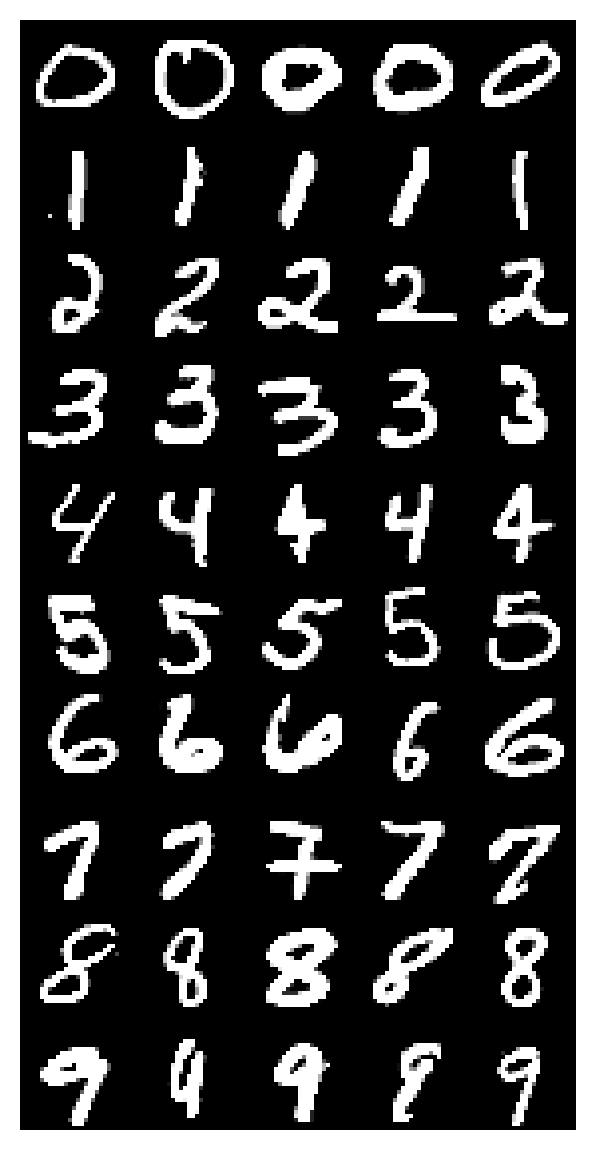

In [98]:
imgs, targets = sample_images(test_loader, n=5, plot = True)

In [102]:
adv_imgs = generate_adversarial(MLP, imgs, targets, epsilon=0.2)

imgs.shape=torch.Size([50, 1, 28, 28])


(-0.5, 139.5, 279.5, -0.5)

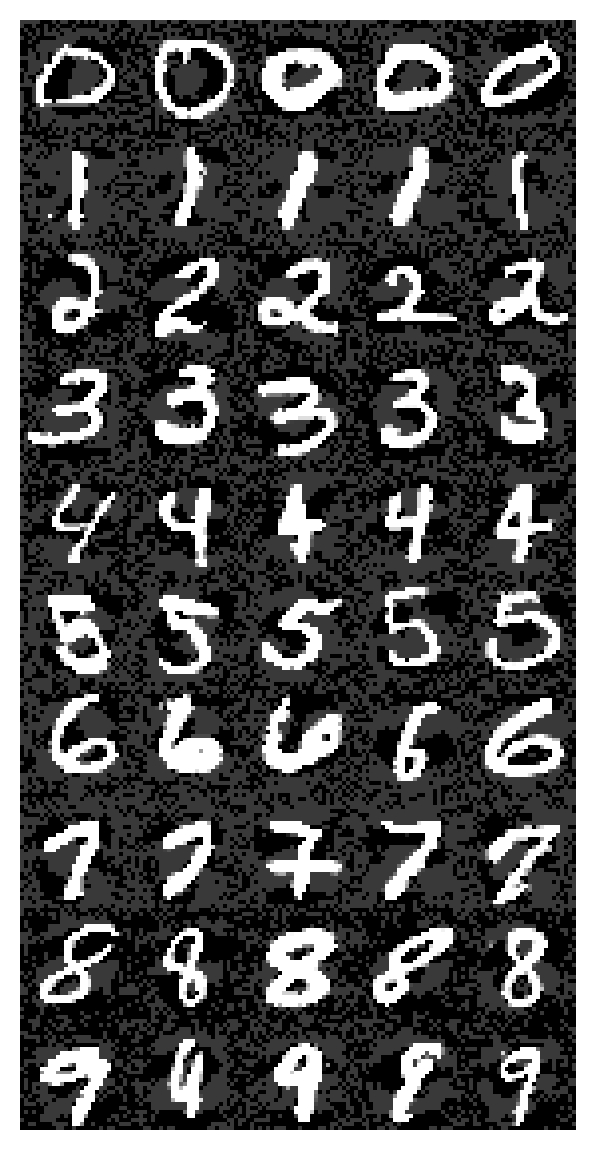

In [103]:
plt.imshow(torch.moveaxis(make_grid(adv_imgs.cpu(), nrow=5, padding=0, normalize=False, pad_value=0), 0,-1))
plt.axis('off')

In [104]:
print(f'{adv_imgs.shape=}')
test_adversarial(MLP, adv_imgs, targets)

adv_imgs.shape=torch.Size([50, 1, 28, 28])
adversarial test accuracy = 4 / 50 = 0.08


### Introduce Feedback Control to MLP for Hebbian Learning **Rules**

In [ ]:
class FB_Function(torch.autograd.Function):
  """
  Gradient computing function class for Hebbian learning.
  """

  @staticmethod
  def forward(context, input, weight, bias=None, nonlinearity=None, target=None):
    """
    Forward pass method for the layer. Computes the output of the layer and
    stores variables needed for the backward pass.

    Arguments:
    - context (torch context): context in which variables can be stored for
      the backward pass.
    - input (torch tensor): input to the layer.
    - weight (torch tensor): layer weights.
    - bias (torch tensor, optional): layer biases.
    - nonlinearity (torch functional, optional): nonlinearity for the layer.
    - target (torch tensor, optional): layer target, if applicable.

    Returns:
    - output (torch tensor): layer output.
    """

    # compute the output for the layer (linear layer with non-linearity)
    output = input.mm(weight.t())
    if bias is not None:
      output += bias.unsqueeze(0).expand_as(output)
    if nonlinearity is not None:
      output = nonlinearity(output)

    # calculate the output to use for the backward pass
    output_for_update = output if target is None else target

    # store variables in the context for the backward pass
    context.save_for_backward(input, weight, bias, output_for_update)

    return output

  @staticmethod
  def backward(context, grad_output=None):
    """
    Backward pass method for the layer. Computes and returns the gradients for
    all variables passed to forward (returning None if not applicable).

    Arguments:
    - context (torch context): context in which variables can be stored for
      the backward pass.
    - input (torch tensor): input to the layer.
    - weight (torch tensor): layer weights.
    - bias (torch tensor, optional): layer biases.
    - nonlinearity (torch functional, optional): nonlinearity for the layer.
    - target (torch tensor, optional): layer target, if applicable.

    Returns:
    - grad_input (None): gradients for the input (None, since gradients are not
      backpropagated in Hebbian learning).
    - grad_weight (torch tensor): gradients for the weights.
    - grad_bias (torch tensor or None): gradients for the biases, if they aren't
      None.
    - grad_nonlinearity (None): gradients for the nonlinearity (None, since
      gradients do not apply to the non-linearities).
    - grad_target (None): gradients for the targets (None, since
      gradients do not apply to the targets).
    """

    input, weight, bias, output_for_update = context.saved_tensors
    grad_input = None
    grad_weight = None
    grad_bias = None
    grad_nonlinearity = None
    grad_target = None

    input_needs_grad = context.needs_input_grad[0]
    if input_needs_grad:
      pass

    weight_needs_grad = context.needs_input_grad[1]
    if weight_needs_grad:
      grad_weight = output_for_update.t().mm(input)
      grad_weight = grad_weight / len(input) # average across batch

      # center around 0
      grad_weight = grad_weight - grad_weight.mean(axis=0) # center around 0

      ## or apply Oja's rule (not compatible with clamping outputs to the targets!)
      # oja_subtract = output_for_update.pow(2).mm(grad_weight).mean(axis=0)
      # grad_weight = grad_weight - oja_subtract

      # take the negative, as the gradient will be subtracted
      grad_weight = -grad_weight

    if bias is not None:
      bias_needs_grad = context.needs_input_grad[2]
      if bias_needs_grad:
        grad_bias = output_for_update.mean(axis=0) # average across batch

        # center around 0
        grad_bias = grad_bias - grad_bias.mean()

        ## or apply an adaptation of Oja's rule for biases
        ## (not compatible with clamping outputs to the targets!)
        # oja_subtract = (output_for_update.pow(2) * bias).mean(axis=0)
        # grad_bias = grad_bias - oja_subtract

        # take the negative, as the gradient will be subtracted
        grad_bias = -grad_bias

    return grad_input, grad_weight, grad_bias, grad_nonlinearity, grad_target

In [ ]:
class FBMultiLayerPerceptron(MultiLayerPerceptron):
  """
  Hebbian multilayer perceptron with one hidden layer.
  """

  def __init__(self, clamp_output=True, **kwargs):
    """
    Initializes a Hebbian multilayer perceptron object

    Arguments:
    - clamp_output (bool, optional): if True, outputs are clamped to targets,
      if available, when computing weight updates.
    """

    self.clamp_output = clamp_output
    super().__init__(**kwargs)


  def forward(self, X, y=None):
    """
    Runs a forward pass through the network.

    Arguments:
    - X (torch.Tensor): Batch of input images.
    - y (torch.Tensor, optional): Batch of targets, stored for the backward
      pass to compute the gradients for the last layer.

    Returns:
    - y_pred (torch.Tensor): Predicted targets.
    """

    h = FB_Function.apply(
        X.reshape(-1, self.num_inputs),
        self.lin1.weight,
        self.lin1.bias,
        self.activation,
    )



    # if targets are provided, they can be used instead of the last layer's
    # output to train the last layer.
    if y is None or not self.clamp_output:
      targets = None
    else:
      targets = torch.nn.functional.one_hot(
          y, num_classes=self.num_outputs
          ).float()

    y_pred = FB_Function.apply(
        h,
        self.lin2.weight,
        self.lin2.bias,
        self.softmax,
        targets
    )

    #### COMPUTE CONTROL SIGNALS FOR EACH LAYER
    criterion = torch.nn.NLLLoss()
    loss = criterion(torch.log(y_pred), y)
    loss.backward() # make sure this doesn't do anything weird

    epsilon = 0.02
    B = torch.random #idk what function to use go google
    control_h = -epsilon * h.grad
    control_y = -epsilon * y_pred.grad

    # J = torch.autograd.function.jacobian()
    ############################################

    h = FB_Function.apply(
        X.reshape(-1, self.num_inputs),
        self.lin1.weight,
        self.lin1.bias,
        self.activation,
    )
    h += control_h



    # if targets are provided, they can be used instead of the last layer's
    # output to train the last layer.
    if y is None or not self.clamp_output:
      targets = None
    else:
      targets = torch.nn.functional.one_hot(
          y, num_classes=self.num_outputs
          ).float()

    y_pred = FB_Function.apply(
        h,
        self.lin2.weight,
        self.lin2.bias,
        self.softmax,
        targets
    )

    y_pred += control_y

    return y_pred

In [ ]:


FB_LR = 1e-4 # lower, since Hebbian gradients are much bigger than backprop gradients

FBMLP = FBMultiLayerPerceptron(
    num_hidden=NUM_HIDDEN,
    num_outputs=10,
    clamp_output=False,
)

FB_optimizer = BasicOptimizer(FBMLP.parameters(), lr=FB_LR)

FB_results_dict = train_model(
    FBMLP,
    train_loader,
    valid_loader,
    FB_optimizer,
    num_epochs=10
    );

plot_results(FB_results_dict, num_classes=10)
plot_scores_per_class(FB_results_dict, num_classes=10)
plot_examples(valid_loader.dataset, MLP=FBMLP, num_classes=10)
plot_weights(FBMLP);

print_results_by_class(FB_results_dict, dataset="train")
print_results_by_class(FB_results_dict, dataset="valid")
_ = test_model(MLP, test_loader)

  0%|          | 0/10 [00:00<?, ?it/s]<ipython-input-26-ff4f429949f8>:65: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  control_h = -epsilon * h.grad
  0%|          | 0/10 [00:00<?, ?it/s]


TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'